# Test a selected model 

This example shows how to load a arbitrary CMIP6 model with daily resolution, preprocess it and predict it with a pre-trained classifier. Note how the classification also works for maximum temperature at the end of the century.

In [1]:
import os
import sys
import pickle
import xarray as xr
import numpy as np
from glob import glob
sys.path.append('../')

import core.core_functions as cf
import core.dataset_functions as df
import core.plot_functions as pf

land_masked = True
global_mean = True

## Load a single dataset

NOTE: we use selected datasets here, which were particularly prone to get confused for observations.

In [2]:
DATAPATH = '../../data/testdata'

# # standard testset (select a temporally out-of-sample period)
# fn = os.path.join(DATAPATH, 'tas_day_CMCC-CM2-HR4_historical_r1i1p1f1_g025.nc')
# ds = xr.open_dataset(fn).sel(time=slice('2005', '2014'))

# fn = os.path.join(DATAPATH, 'tas_day_ERA5_historical_r1_g025.nc')
# ds = xr.open_dataset(fn).sel(time=slice('2005', '2014'))

# # future projections under a high emission pathway
# fn = os.path.join(DATAPATH, 'tas_day_CMCC-CM2-SR5_ssp585_r1i1p1f1_g025.nc')
# ds = xr.open_dataset(fn).sel(time=slice('2091', '2100'))

# # using tasmax instead of tas also works
# fn = os.path.join(DATAPATH, 'tasmax_day_GFDL-ESM4_ssp370_r1i1p1f1_g025.nc')
# ds = xr.open_dataset(fn).sel(time=slice('2091', '2100'))

# # using data from HighResMIP
# fn = os.path.join(DATAPATH, 'tas_day_HadGEM3-GC31-MM_hist-1950_r1i1p1f1_g025.nc')
# ds = xr.open_dataset(fn)

# using decadal predictions reveals the effect of initialization
fn = os.path.join(DATAPATH, 'tas_day_CanESM5_dcppA-hindcast_s2005-r17i1p2f1_gn_20060101-20151231_g025.nc')
ds = xr.open_dataset(fn)

dataset_name = os.path.basename(fn).split('_')[2]
varn = os.path.basename(fn).split('_')[0]
varn = cf.varn_map.get(dataset_name, varn)  # observational are not CMORized
print(f'{dataset_name=}, {varn=}')

da = ds[varn]
da

dataset_name='CanESM5', varn='tas'


<xarray.DataArray 'tas' (time: 3650, lat: 72, lon: 144)>
[37843200 values with dtype=float32]
Coordinates:
  * time     (time) object 2006-01-01 12:00:00 ... 2015-12-31 12:00:00
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    height   float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    comment:        near-surface (usually, 2 meter) air temperature
    original_name:  ST
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-09-20T05:13:00Z altered by CMOR: Treated scalar dime...

## Load trained classifier 
- classifier trained on all models
- classifier not trained on the tested model

In [3]:
# # classifier trained on all models
# savename =  'logreg{}.sav'.format(('_lm' if land_masked else '') + ('_gm' if global_mean else ''))
# savename = os.path.join('../../data/trained_classifiers', savename)

# classifier trained all models EXCEPT the tested dataset
savename =  'logreg{}_*{}*.sav'.format(
    ('_lm' if land_masked else '') + ('_gm' if global_mean else ''),
    dataset_name)
savename = glob(os.path.join('../../data/trained_classifiers', 'outsample', savename))[0]

logreg = pickle.load(open(savename, 'rb'))

## Look at the raw data

<GeoAxesSubplot: title={'center': 'height = 2.0 [m]'}>

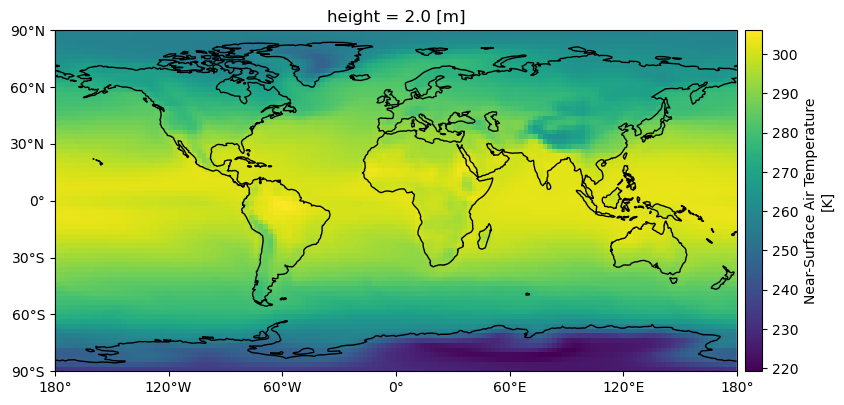

In [4]:
pf.plot_map(da.mean('time', keep_attrs=True))

In the daily map below we see the influence of daily weather even when looking at absolute temperatures

<GeoAxesSubplot: title={'center': 'time = 2006-02-26 12:00:00, height = 2.0 [m]'}>

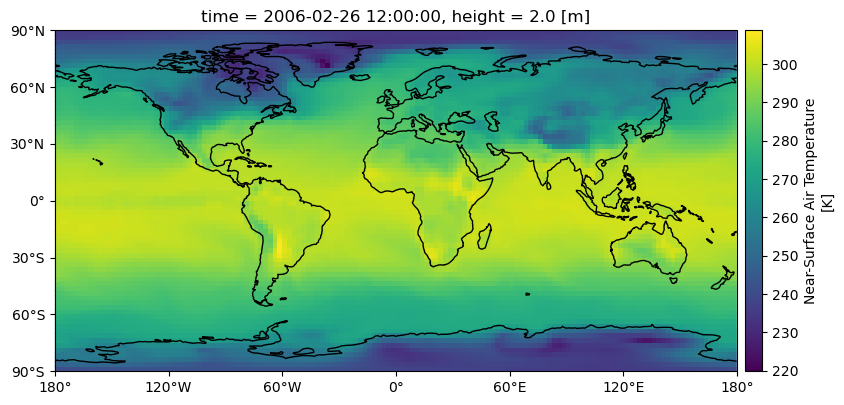

In [5]:
pf.plot_map(da.isel(time=56))

In [6]:
da2 = cf.preprocess(da, land_masked=land_masked, global_mean=global_mean)

<GeoAxesSubplot: title={'center': 'height = 2.0 [m]'}>

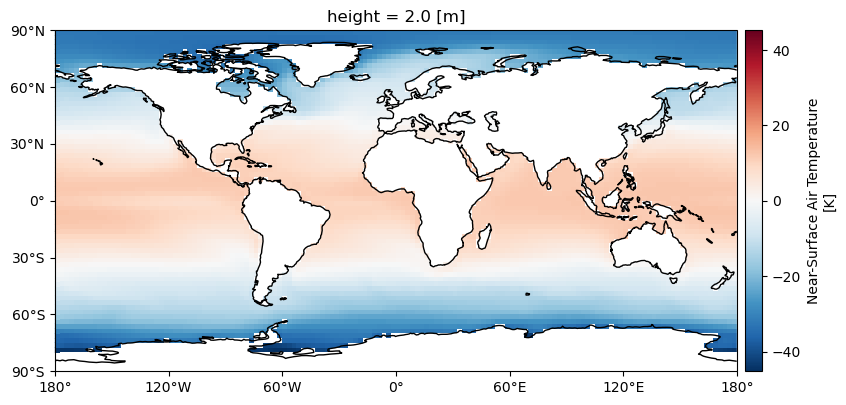

In [7]:
pf.plot_map(da2.mean('time', keep_attrs=True))

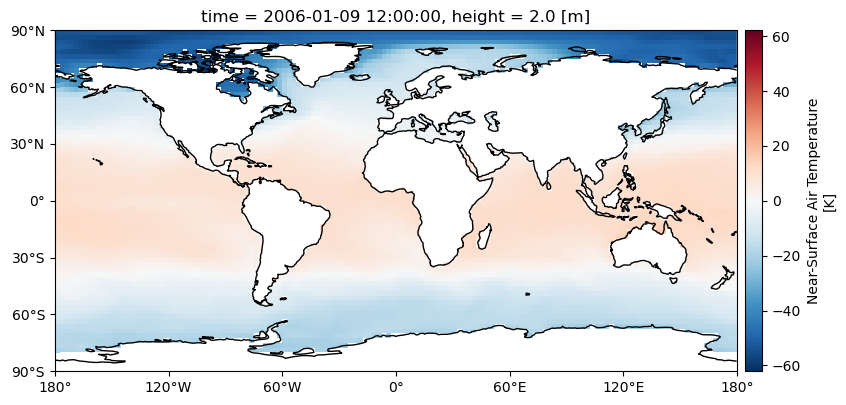

In [9]:
ax = pf.plot_map(da2.isel(time=8))

import matplotlib.pyplot as plt
savename =  'logreg{}_{}.png'.format(
    ('_lm' if land_masked else '') + ('_gm' if global_mean else ''),
    dataset_name)
plt.savefig(os.path.join('../../plots', savename))

## Convert to samples 

In [10]:
da2 = da2.stack(feature=['lat', 'lon'])
XX = da2.values
# NOTE: when using an unknown dataset the ID needs to be set manually
# model: 0, observation: 1
yy = df.get_category_ids([dataset_name] * da['time'].size)

nan_mask = np.any(np.isnan(XX), axis=0)
XX = XX[:, ~nan_mask]

# Results

## Test accuracy

In [11]:
logreg.score(XX, yy)

0.9909589041095891

## Reliability diagram

<AxesSubplot: xlabel='Confidence', ylabel='Accuracy'>

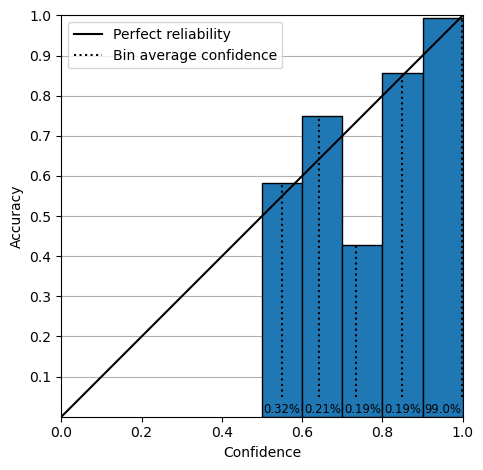

In [12]:
pf.plot_reliability_diagram(logreg, XX, yy)

## Wrong timesteps (in particular for dfPP)

In [13]:
yp = logreg.predict(XX)
y_correct = yp == yy

In [14]:
da['time'][~y_correct]

<xarray.DataArray 'time' (time: 33)>
array([cftime.DatetimeNoLeap(2006, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 3, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 4, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 5, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 6, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 7, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 8, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 9, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 10, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 11, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 12, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 13, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 14, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 17, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 18, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 19, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 20, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 21, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 22, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 25, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 28, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 1, 31, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 5, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 6, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 9, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 12, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2006, 2, 21, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2006-01-01 12:00:00 ... 2006-02-21 12:00:00
    height   float64 2.0
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

## Systematic patterns in datasets that got misclassified

<GeoAxesSubplot: title={'center': 'height = 2.0 [m]'}>

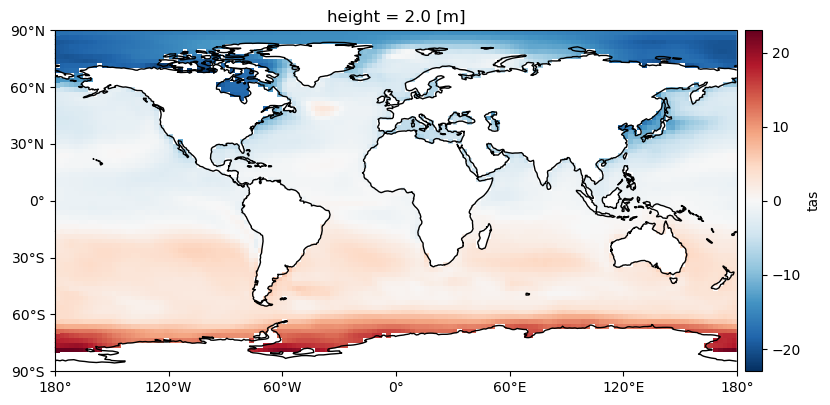

In [15]:
pf.plot_map(da2[~y_correct].mean('time') - da2[y_correct].mean('time'))